In [1]:
#! /usr/bin/python3

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

#  Reading in log file
df = pd.read_csv('Logs/Log00020.csv', delimiter=',', low_memory=False) 

# Removing battery level, roll, pitch, K&Z Temp, and NA row that was added as a buffer.
t_fract = df['Time [UTC]']
t_fract = (t_fract.str[11:13])
df_date_time = df['Time [UTC]']
t_fract = t_fract.astype(int)

# Dropping exta info
df = df.iloc[: ,3:]
df = df.drop(columns=[" Bat [V]", " R_u [deg]", " P_u [deg]", " Temp RTC [C]"])
df = df.iloc[: ,:-2]

cols = [' UVA_u', ' UVB_u', ' White_u', ' Vis_u [lx]', ' IR_S_u',
       ' IR_M_u']
       
y = df[[' Pyro [uV]']]
X = df.drop(columns=[' Pyro [uV]', " TempOB [C]"])

# Verify Correct data
X.dropna(axis=0)
X = np.array(X, dtype=float)
y = np.array(y, dtype=float)

In [2]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Create Decision Tree classifer object
clf = DecisionTreeRegressor()

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print(clf.score(X_test, y_test))

0.9951225612855082


In [3]:
# Plotting real vs generated with tree
# Running the model on the entire set, so the shaps allign
all_predicted_Y = clf.predict(X)

## Making the data more presentable to work with
Now that the entire dataset has been run through the model, we are ecreting the origanal pandas dataframe for easier analysis

In [4]:
from datetime import date, time, datetime

# Adding time in UTC back as a pandas datetime object
utc_dt = pd.to_datetime(df_date_time)
df["Time [UTC]"] = utc_dt

# Localizing to central time
df["Time [CT]"] = df["Time [UTC]"].dt.tz_localize('UTC').dt.tz_convert('US/Central')

# Adding te predicted values to the dataframe
df["Predicted"] = all_predicted_Y

# How much each value is off by
df["Error"] = abs(df[" Pyro [uV]"] - df["Predicted"]) / df[" Pyro [uV]"]

df.head()

,TempOB [C],Pyro [uV],UVA_u,UVB_u,White_u,Vis_u [lx],IR_S_u,IR_M_u,Time [UTC],Time [CT],Predicted,Error
0,70.60,8546.88,466,115200,9789,11783.58,0.27,0.35,2023-06-06 21:00:00,2023-06-06 16:00:00-05:00,8546.88,0.000000
1,70.65,8687.50,474,117248,9886,11938.41,0.28,0.35,2023-06-06 21:00:06,2023-06-06 16:00:06-05:00,8687.50,0.000000
2,70.71,8796.88,478,118528,10014,11918.13,0.28,0.36,2023-06-06 21:00:12,2023-06-06 16:00:12-05:00,8796.88,0.000000
3,70.76,8781.25,475,117248,9890,11921.82,0.28,0.35,2023-06-06 21:00:18,2023-06-06 16:00:18-05:00,8718.75,0.007117
4,70.82,8718.75,473,116736,9837,11849.93,0.28,0.35,2023-06-06 21:00:24,2023-06-06 16:00:24-05:00,8718.75,0.000000


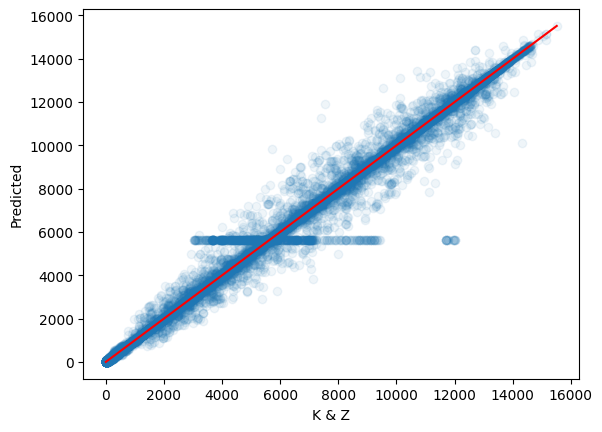

In [5]:
# Plotting Predicted vs actual values

plt.scatter(df[" Pyro [uV]"], df["Predicted"], label = "Predicted vs Actual Values", alpha=0.07)
plt.xlabel("K & Z")
plt.ylabel("Predicted")

p1 = max(max(df["Predicted"]), max(df[" Pyro [uV]"]))
p2 = min(min(df["Predicted"]), min(df[" Pyro [uV]"]))
plt.plot([p1, p2], [p1, p2], 'r-')

plt.show()

<Axes: xlabel='Time [CT]', ylabel='Error'>

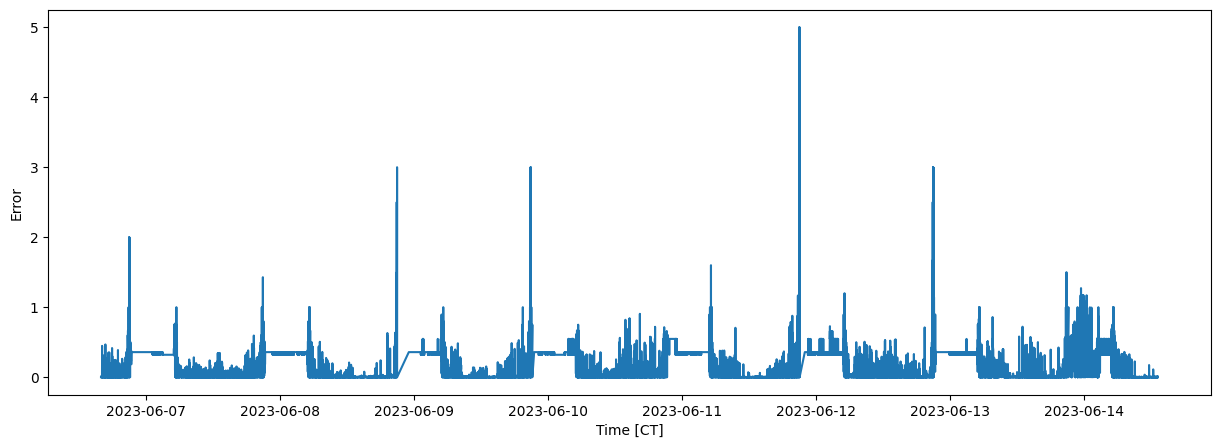

In [6]:
# Model Accuracy over time during wildfires

plt.figure(figsize=(15, 5))
sns.lineplot(data=df, x="Time [CT]", y="Error")

<Axes: >

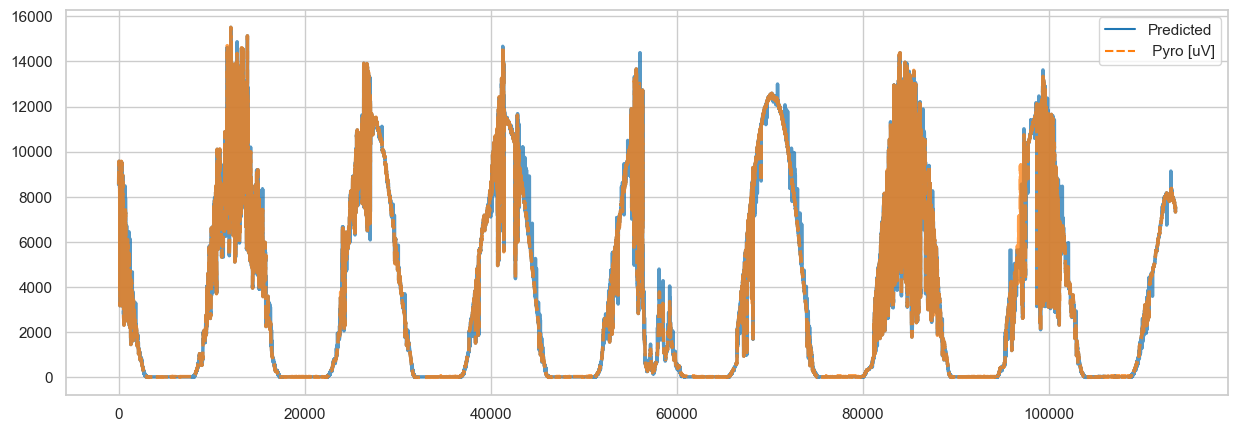

In [12]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15, 5))
sns.lineplot(data=(df["Predicted"],df[" Pyro [uV]"]), palette="tab10", linewidth=2.5, alpha=0.75)

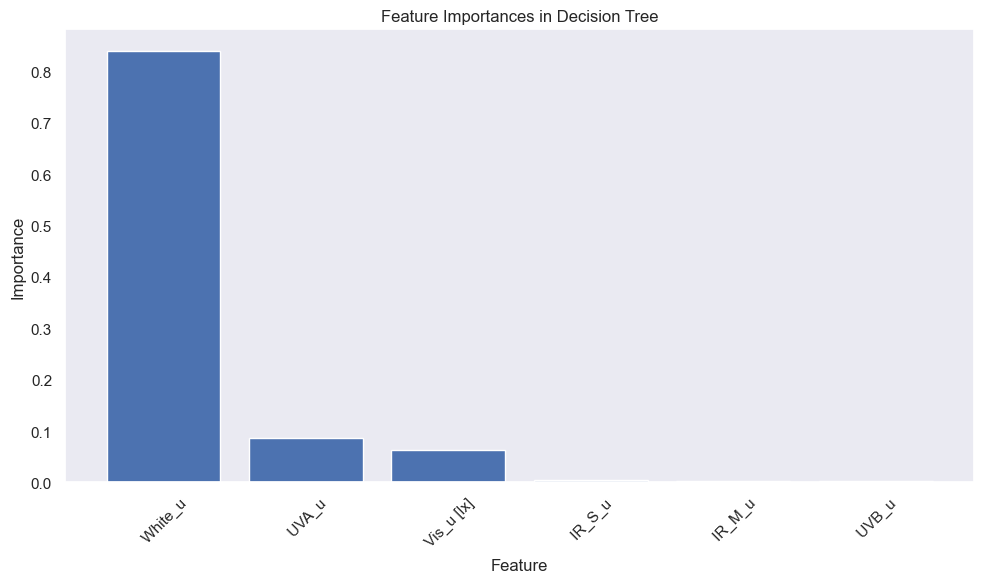

In [17]:
feature_importances = clf.feature_importances_
feature_names = cols

indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = feature_importances[indices]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), sorted_importances, align="center")
plt.xticks(range(X.shape[1]), sorted_feature_names, rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances in Decision Tree")
plt.tight_layout()
plt.show()